# Preprocess Data

Before running any analysis on the data, let's process it and fit it to the lower contiguous United States using a [shapefile from the US Census](https://www.census.gov/geographies/mapping-files/time-series/geo/cartographic-boundary.html) (2024 > 1 : 500,000 > cb_2024_us_region_500k > cb_2024_us_region_500k.shp). We can then process this as follows (due to rate limits, it's necessary to download separate files and then merge them):

In [ ]:
# import necessary packages
import geopandas as geop
import xarray as xarr
import rioxarray 

# define NetCDF data, combine
temp_data_location = "rough_CONUS_2mtemperature_1988.nc"
precipitation_data_location = "rough_CONUS_precipitation_1988.nc"
temp_data = xarr.open_dataset(temp_data_location)
precipitation_data = xarr.open_dataset(precipitation_data_location)

shapefile = "../data/cb_2024_us_state_500k/cb_2024_us_state_500k.shp"

# load datasets
roughData = xarr.merge([temp_data, clwc_data])
conus_shapefile = geop.read_file(shapefile)

# filter to continental US; filter by two STUSPS, two-letter abbreviation for states and territories
conusSeparate = conus_shapefile[~conus_shapefile['STUSPS'].isin(['AK', 'HI', 'GU', 'MP', 'PR', 'VI', 'AS'])]

# dissolve to make continuous boundary
conus_boundary = conusSeparate.dissolve()

# now, write the same coordinate reference system 
roughData = roughData.rio.set_spatial_dims(x_dim="longitude", y_dim='latitude')
cleanData = roughData.rio.write_crs(conus_boundary.crs)


#### Clipping (GeoPandas to GeoJSON), Saving

Now we need to ensure we can clip it to fit the border of the continental United States,  including those partially on the border (drop=False). This will check if each grid cell is in or overlapping with the US polygon boundary.

In [2]:
from shapely.geometry import mapping

cleanData_clipped = cleanData.rio.clip(conus_boundary.geometry.apply(mapping), conus_boundary.crs, drop=False)
cleanData_clipped.to_netcdf("CONUS_clipped_precipitation_temperature_1988.nc")

Let's now make a heatmap for the temperature on the first of August to ensure this worked preprocess worked ([reference](https://scitools.org.uk/cartopy/docs/v0.15/matplotlib/intro.html)).

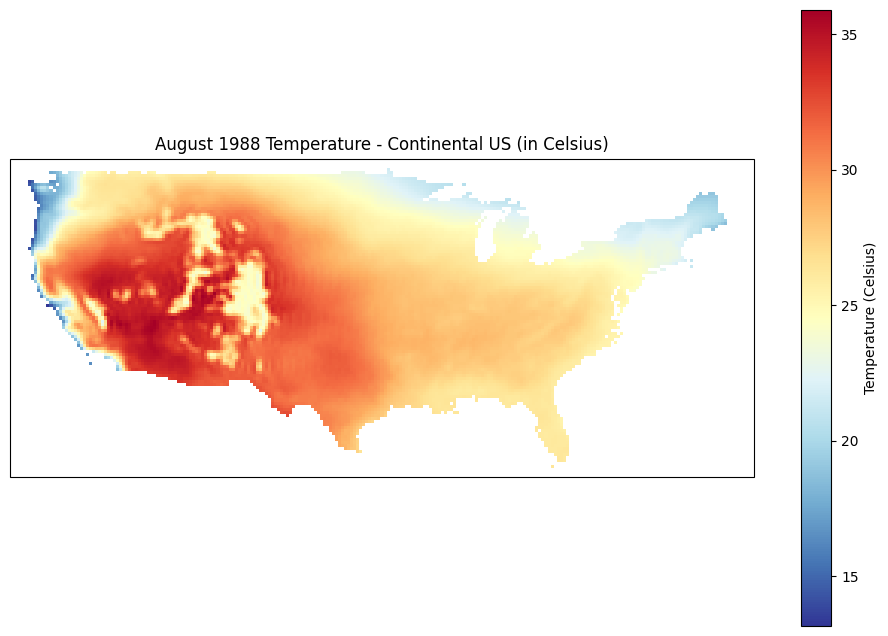

In [4]:
import matplotlib.pyplot as plot
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# get August data, and then the first temperature data point of the month
august_data = cleanData_clipped.where(cleanData_clipped.valid_time.dt.month == 8, drop=True)
august_temp = august_data['t'][0] - 273.15 # in Kelvin

# Create demonstration map
theFigure = plot.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# cmap defines color map, transform makes it a flat projection
thePlot = august_temp.plot(transform=ccrs.PlateCarree(), cmap='RdYlBu_r', add_colorbar=True)

# set label for color
thePlot.colorbar.set_label('Temperature (Celsius)')

# title, show
plot.title("August 1988 Temperature - Continental US (in Celsius)")
plot.show()
